# Aim of code

Script for fitting disentanglement time at 298K using data at 600-800K.
No restriction of a parameter in curver fit.


In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# List of FPT at each temperature that protein unfold, Criteria: Q<= 0.3 for 1000 ps
FPT_dict = {
    'FPT_600' : np.array([ 6.78, 8.26, 13.35, 15.49, 12.56, 12.96, 11.56, 13.0, 14.16, 11.59, 9.86, 8.98, 12.08, 11.34, 18.48, 12.06, 13.17, 7.39, 11.09, 12.6, 11.6, 9.07, 19.31, 9.14, 14.08, 16.38, 10.67, 12.59, 11.46, 12.23, 21.12, 9.23, 6.9, 16.1, 11.16, 21.69, 11.5, 13.32, 9.8, 6.9, 10.19, 9.99, 11.68, 9.82, 7.18, 8.62, 11.13]),
    'FPT_650' : np.array([ 4.29, 3.71, 4.11, 3.21, 2.77, 3.76, 6.18, 4.92, 2.73, 4.22, 3.85, 5.1, 3.27, 4.75, 2.32, 3.91, 3.86, 3.13, 4.59, 3.13, 3.29, 3.57, 4.59, 3.96, 2.79, 4.7, 3.95, 2.71, 3.61, 3.33, 3.3, 2.34, 4.83, 3.59, 2.62, 4.35, 3.54, 5.66, 3.22, 4.4, 3.94, 2.44, 2.84, 5.91, 3.93, 3.91, 4.51, 2.24, 3.24]),
    'FPT_700' : np.array([ 1.37, 1.47, 1.86, 2.04, 1.19, 1.74, 1.86, 1.9, 1.36, 1.16, 1.53, 2.18, 2.64, 2.02, 1.39, 1.52, 1.72, 1.81, 1.42, 1.31, 1.44, 1.26, 2.28, 2.01, 2.07, 2.07, 1.59, 2.11, 1.72, 2.11, 1.36, 2.02, 1.47, 1.59, 1.76, 2.12, 2.14, 1.55, 1.72, 1.42, 0.93, 1.68, 1.73, 2.01, 2.16, 2.29, 2.08, 1.53, 1.54, 1.31]),
    'FPT_750' : np.array([ 0.81, 0.79, 1.23, 0.92, 0.8, 0.92, 0.94, 1.41, 0.88, 0.77, 0.99, 0.73, 1.09, 0.88, 1.01, 0.99, 0.82, 1.19, 0.83, 0.87, 0.89, 0.87, 0.86, 1.15, 0.95, 0.72, 0.75, 0.74, 0.77, 1.09, 0.82, 0.63, 0.86, 1.17, 0.83, 0.91, 0.69, 1.03, 1.07, 0.76, 0.93, 0.93, 0.96, 0.65, 0.81, 0.82, 0.73, 0.7, 0.88, 0.88]),
    'FPT_800' : np.array([ 0.67, 0.45, 0.61, 0.55, 0.57, 0.45, 0.48, 0.53, 0.6, 0.52, 0.69, 0.39, 0.42, 0.53, 0.4, 0.54, 0.38, 0.49, 0.72, 0.42, 0.47, 0.67, 0.46, 0.55, 0.55, 0.46, 0.72, 0.74, 0.47, 0.41, 0.47, 0.71, 0.52, 0.81, 0.53, 0.53, 0.56, 0.58, 0.65, 0.58, 0.69, 0.38, 0.65, 0.56, 0.41, 0.47, 0.44, 0.47, 0.5, 0.54])
}

In [3]:
# Matplotlib setting
fontsize = 12 # set variable for fontsize
linewidth = 2 # set variable for line width
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['axes.labelsize'] = 'small'
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 4
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['xtick.labelsize'] = 'x-small'
matplotlib.rcParams['ytick.labelsize'] = 'x-small'
matplotlib.rcParams['legend.fontsize'] = 'x-small'
matplotlib.rcParams['figure.dpi'] = 600

# config for matplotlib
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.linewidth'] = 2 #set the value globally

# set tick width
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 2

In [4]:
"""
Functions definition
"""


def cal_Su_list(first_time_zero, time_end, dt=0.01):
    """
    Calculate the survival probability.

    Parameters:
    - first_time_zero (array-like): Array of first passage times.
    - time_end (float): The end time for calculating the survival probability.
    - dt (float, optional): Time step for the calculation. Default is 0.01.

    Returns:
    - ts (numpy.ndarray): Array of time points.
    - survival_probability (numpy.ndarray): Array of survival probabilities corresponding to the time points.
    """
    time_range = np.arange(0, time_end, dt)
    survival_probability = np.array([np.count_nonzero(first_time_zero >= t) / len(first_time_zero) for t in time_range])
    return time_range, survival_probability

def exp_fun(x, k, t0):
    """
    Exponential function used for fitting survival probability.

    Parameters:
    - x (numpy.ndarray): Time variable.
    - k (float): Rate constant.
    - t0 (float): Time offset.

    Returns:
    - numpy.ndarray: The value of the exponential function at time `x`.
    """
    t = x - t0
    t[t < 0] = 0
    return np.exp(-k * t)

def quadratic_fun(x, a, b, c):
    """
    Quadratic function for fitting purposes.

    Parameters:
    - x (numpy.ndarray): Independent variable (1/T).
    - a (float): Quadratic term coefficient.
    - b (float): Linear term coefficient.
    - c (float): Constant term.

    Returns:
    - numpy.ndarray: The value of the quadratic function at `x`.
    """
    return a * x**2 + b * x + c

def get_ln_kapp(FPT):
    """
    Calculate the natural logarithm of the apparent rate (ln_kapp) from the first passage time (FPT) array.

    Parameters:
    - FPT (array-like): First passage time array.

    Returns:
    - float: The natural logarithm of the apparent rate (ln_kapp).
    """
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    kopt, _ = curve_fit(exp_fun, ts, Su_list, bounds=(0, np.inf), maxfev=5000)
    k, t0 = kopt[0], kopt[1]
    kapp = 1 / (t0 + 1 / k)
    return np.log(kapp)


def write_SU(FPT, Temp):
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    with open(f'survival_{Temp}.dat', 'w') as f:
        for t, s in zip(ts, Su_list):
            f.write(f'{t:.2f}    {s:.3f}\n')

            

            
def bootstrap_FPT_dict(Temperature_FPT_dict):
    # Create a new dictionary for the random choices
    random_FPT_dict = {}

    # Apply np.random.choice with replacement to each array in the original dictionary
    for key in Temperature_FPT_dict:
        random_FPT_dict[key] = np.random.choice(Temperature_FPT_dict[key], size=len(Temperature_FPT_dict[key]), replace=True)

    # Print the new dictionary with random choices
#     print(random_FPT_dict)
    return random_FPT_dict

def extrapolate_ln_kapp_target_temperature(temperature_list, Temperature_FPT_dict, target_temp=298):
    """
    Extrapolates the natural logarithm of kapp (ln(kapp)) for a target temperature using quadratic fitting.
    
    Parameters:
    temperature_list (list of float): List of temperatures to be used for fitting.
    Temperature_FPT_dict (dict): Dictionary containing FPT values for each temperature. Keys should be formatted as 'FPT_<temperature>'.
    target_temp (float, optional): The target temperature for which ln(kapp) is to be extrapolated. Default is 298 K.
    
    Returns:
    tuple: 
        - numpy.ndarray: Inverse temperatures including the target temperature.
        - numpy.ndarray: ln(kapp) values including the extrapolated value for the target temperature.
        - float: Coefficient of determination (R^2) for the quadratic fit.
        - numpy.ndarray: Coefficients of the quadratic function (a, b, c).
    """
    # Initialize an array to store inverse temperatures and ln(kapp) values
    num_temperatures = len(temperature_list)
    inv_temperature_ln_kapp = np.zeros((num_temperatures + 1, 2))
    
    for i, temperature in enumerate(temperature_list):
        inv_temperature_ln_kapp[i, 0] = 1/temperature
        inv_temperature_ln_kapp[i, 1] = get_ln_kapp(Temperature_FPT_dict[f'FPT_{temperature}'])
        
    # Fit a quadratic function to the data points (excluding the target temperature)
    kopt_target, _ = curve_fit(quadratic_fun, inv_temperature_ln_kapp[:-1, 0], inv_temperature_ln_kapp[:-1, 1], maxfev=5000)
    
    # Calculate the coefficient of determination (R^2) for the fit
    predicted_ln_kapp = quadratic_fun(inv_temperature_ln_kapp[:-1, 0], *kopt_target)
    cc_target = np.corrcoef(inv_temperature_ln_kapp[:-1, 1], predicted_ln_kapp)[0, 1] ** 2
    
    # Extrapolate ln(kapp) for the target temperature
    ln_kapp_target = quadratic_fun(1 / target_temp, *kopt_target)

    # Add the target temperature and its extrapolated ln(kapp) value to the array
    inv_temperature_ln_kapp[-1,:] = 1/target_temp, ln_kapp_target
    return inv_temperature_ln_kapp[:, 0], inv_temperature_ln_kapp[:, 1], cc_target, kopt_target


def convert_ln_kapp_to_human(ln_kapp, human_type='day'):
    """
    Convert the logarithm of kapp (ln_kapp) to human time.

    Parameters:
    - ln_kapp (float): The natural logarithm of kapp.
    - human_type (str): The desired unit of human time. Can be 'second', 'hour', or 'day'. Default is 'day'.

    Returns:
    - float: The converted time in the specified human time unit.
    """
    scaled_factor = 143
    
    # Calculate the simulated life time in nanoseconds
    simulated_life_time = 1 / np.exp(ln_kapp)
    
    # Convert simulated life time from nanoseconds to human time
    conversion_factors = {
        'second': 1,
        'hour': 1 / 3600,
        'day': 1 / 86400
    }
    
    if human_type not in conversion_factors:
        raise ValueError("Invalid human_type. Expected one of: 'second', 'hour', 'day'")

    lifetime = simulated_life_time / 1e9 * conversion_factors[human_type]
    scaled_lifetime = scaled_factor * lifetime
    return lifetime, scaled_lifetime


In [5]:
target_temp = 298
temperature_list = [800, 750, 700, 650, 600]

In [6]:
mean_res = extrapolate_ln_kapp_target_temperature(temperature_list, FPT_dict)

In [9]:
# bootstrapping
nboot=10000
i=0
ln_kapp_array = np.zeros((len(temperature_list)+1, nboot))
while i < nboot:
    random_FPT_dict = bootstrap_FPT_dict(FPT_dict)
    res = extrapolate_ln_kapp_target_temperature(temperature_list, random_FPT_dict, target_temp)
    print(res[2], res[1][-1])
    if res[2] >= 0.9:
        print(i)
        ln_kapp_array[:,i] = res[1]
        i+=1
    

0.999985125095254 -29.161900709875763
0
0.9989305541899471 -29.219639001700813
1
0.9992507653889815 -27.899538266043457
2
0.9990607945863822 -30.056038914781485
3
0.9999649497937889 -29.2778752450781
4
0.9994380709539852 -31.74038398572863
5
0.9974289237456653 -27.84104157035194
6
0.9999701128769014 -28.81560518083122
7
0.9998656467926108 -33.52560800065935
8
0.9994268305872378 -29.144235563815993
9
0.9999600644299744 -26.82710394022636
10
0.9999320004570347 -27.9554510648075
11
0.9998877461448668 -29.238966259532667
12
0.9996330082293275 -30.060959114262083
13
0.9998637239707191 -31.397204924236807
14
0.9983314401136193 -31.705664152133494
15
0.9997928299968979 -29.743565792497492
16
0.9996759372822857 -31.10049873033395
17
0.9995882190277751 -29.752666182362173
18
0.9997762869166839 -29.653103796173568
19
0.998593513370993 -27.774424003447663
20
0.9994832578473443 -33.79317580192825
21
0.9997462481572268 -29.908465558408984
22
0.999724405254896 -30.990339625441354
23
0.99932849825300

0.9999825952202018 -27.351924044389268
201
0.9993816801075446 -27.846049692923334
202
0.9999889829580448 -30.07747147917424
203
0.999485865370327 -31.519065175259062
204
0.9990764949634005 -32.77229799132541
205
0.9998296475863407 -28.778381754019676
206
0.9997879654548387 -28.111107284320024
207
0.9995763914960808 -31.342697977919315
208
0.9996907720496533 -28.668791922849486
209
0.9981764199797849 -25.70934979685938
210
0.9996652952845674 -28.677813418884632
211
0.9994998327841484 -24.511005706337386
212
0.999273491710496 -30.325674911361705
213
0.9989680836205957 -27.082078461504015
214
0.9997578416460956 -31.230549227907773
215
0.9970427953536418 -31.763752407613428
216
0.9975808004461681 -31.048294934823787
217
0.999907785538177 -27.36479928001836
218
0.9992113514760844 -31.522412777004913
219
0.9999080343038357 -26.710848968583683
220
0.9988697386611737 -25.353453149807876
221
0.999735238096943 -34.88358122477675
222
0.9995930263660521 -31.874491451842626
223
0.997383740172296 -2

0.9997282228605896 -25.190341004190515
395
0.9997547853680075 -29.092873310863453
396
0.9996442467608865 -24.98461517353472
397
0.9997476098761845 -28.14210141863448
398
0.9999524827561173 -26.184727231479496
399
0.9997184286748483 -30.881556740711854
400
0.9980959821844061 -34.77840342454944
401
0.9997619469978697 -28.55979421972957
402
0.9996976241585726 -26.866202805128566
403
0.9989337562855757 -31.58261311365334
404
0.9992667550726603 -29.448217564267576
405
0.9999191490979265 -33.768232655528635
406
0.9997713463075335 -25.072814310801938
407
0.9994527843894195 -27.96284799117361
408
0.9995747934477952 -31.19908638040204
409
0.9994157202236708 -30.2098461267468
410
0.9998772694449968 -31.202999385091076
411
0.9989153008305409 -31.306447550683135
412
0.9996790637299084 -30.856627992030415
413
0.9993675487627134 -33.44570352762539
414
0.9995537786554916 -26.772938164389473
415
0.9998609582688592 -35.45768178956079
416
0.9985695405726172 -26.72077676224941
417
0.9992177521741118 -38.

0.9997667741376826 -26.23605676554458
590
0.9997440051068387 -27.073862056790638
591
0.998253432402699 -25.431696189942294
592
0.9991938244351501 -35.69605036052132
593
0.9999129525544375 -26.37225125683733
594
0.9999070802164837 -28.24623038687913
595
0.9993721687129867 -29.371643668683348
596
0.9996572792861305 -32.499058567466264
597
0.9997227454340201 -27.06494355937156
598
0.9999740991365482 -30.124505609955285
599
0.9993202478101783 -29.701575723332425
600
0.9996752217279652 -26.87707975075974
601
0.9996227947640953 -28.977683148091145
602
0.9997184725971019 -23.01116650002067
603
0.9996967682825082 -32.73593247260019
604
0.9994203595156879 -25.47965505383199
605
0.9999397031753327 -32.06024365063394
606
0.999608371086426 -27.19657889335992
607
0.9986487328664624 -31.54479271941046
608
0.99958691113782 -23.56481386141965
609
0.9996368485948516 -34.801595025663445
610
0.998689191731417 -27.999609108387634
611
0.9993085893232994 -35.30573742166854
612
0.999464135555158 -29.13269768

0.9993925592654024 -36.713072012629404
784
0.9992464196545847 -34.08413850076743
785
0.9995799878210477 -27.05979151870732
786
0.9992349009661516 -29.611292715414454
787
0.9989963426750945 -30.770856480379642
788
0.9997933929830853 -28.821213356090134
789
0.9998550271016382 -29.832280853476508
790
0.9994360183210363 -31.369150617696263
791
0.9990213379949968 -25.559838912278472
792
0.9994826922211605 -31.367571582935494
793
0.9989559265154782 -32.30323510514618
794
0.9997852110232078 -24.54452774901126
795
0.9998622821442615 -29.43861465738212
796
0.9991613539832611 -32.52106253771726
797
0.999916860817688 -31.373114794132718
798
0.9996117921670487 -31.36001070940243
799
0.9999371082105877 -32.693407285776026
800
0.9993011303281882 -28.996494996477423
801
0.9995725196573343 -39.365317099802716
802
0.999937102999962 -25.82330438500259
803
0.9994248308604969 -26.101567250189078
804
0.9997056676188675 -28.067824078781758
805
0.9997182737895687 -29.444984638748505
806
0.9996623789543251 -3

0.9999098003609269 -27.040035716649765
978
0.9990456315528522 -30.26839430418184
979
0.9998204747280751 -32.26502078480032
980
0.9995742983912779 -31.501344788767053
981
0.9995012293573105 -31.557012592456275
982
0.9993871207973815 -31.42270778354844
983
0.999363544746274 -34.0397564182773
984
0.9998745434779279 -27.68307476701286
985
0.9984966731385753 -27.24833972005447
986
0.9997354843192713 -23.708865207934018
987
0.998364551076128 -33.20726093463425
988
0.9997391554756417 -31.12502612789546
989
0.9997240529740178 -31.70950939763652
990
0.9991815404057379 -28.345281410090795
991
0.9993615022262508 -33.13462806473346
992
0.9995411730009773 -33.04256389728905
993
0.9999311128328846 -25.92055904747509
994
0.9997469266643655 -35.24710876988887
995
0.9997553597940498 -31.321423582425407
996
0.9993164651146277 -28.34962414829502
997
0.9998856938539853 -34.8908110737335
998
0.9996795604578208 -26.99238032359996
999
0.9999014783080925 -37.76296002277775
1000
0.999339204095778 -32.304548202

0.9995480686680284 -29.047172623950313
1172
0.9990512697105735 -33.57699387681529
1173
0.9996142080189806 -31.180089488452385
1174
0.9994504544145176 -28.990928063056852
1175
0.9994208590746119 -26.018912065666658
1176
0.9997751670175727 -32.615097225886686
1177
0.9994988612417489 -31.0711841509455
1178
0.9995541212006106 -28.90750515872157
1179
0.9998525967674716 -26.30817139877597
1180
0.999960255271929 -26.508526551292455
1181
0.9993109608008598 -33.76898535823444
1182
0.9991261671318584 -36.5918111181926
1183
0.9998713763442343 -27.13451791011506
1184
0.9997008951257037 -25.50896906043269
1185
0.9988410449838775 -30.084088842758483
1186
0.9997702200140433 -26.108006436665946
1187
0.9999536507918475 -33.18694413686472
1188
0.9988110926049502 -29.57586076319582
1189
0.9991004819730502 -29.436283804747617
1190
0.9996367170745611 -27.32134474622871
1191
0.9997154943423319 -33.81442112921239
1192
0.99850683488029 -31.71246991248708
1193
0.9995305994423994 -27.48121277523231
1194
0.99927

0.9996060441891522 -28.801031546804577
1365
0.9995623538290874 -34.41675451416713
1366
0.9996324120931109 -34.009861032360604
1367
0.9992154641820871 -26.347878793074567
1368
0.9990020121719103 -31.984586509414214
1369
0.9997321972400546 -29.182435548043255
1370
0.9994035841002821 -33.1973658136407
1371
0.9996291859188763 -30.336255408905743
1372
0.9997446288004083 -31.226736364201784
1373
0.9982092151281917 -34.04318703823237
1374
0.9997870135671837 -34.559518548756785
1375
0.999924633589195 -28.850618908693505
1376
0.9993795719188913 -34.10715416142513
1377
0.9993994739580425 -28.96769335985174
1378
0.9999433967466843 -30.228327218840647
1379
0.9997384973070221 -32.122770982900626
1380
0.9984782048906614 -33.226762808800785
1381
0.9996557949665972 -32.92721421427921
1382
0.9990685796557754 -32.398295100743674
1383
0.9991912956545669 -28.98984970202662
1384
0.9991931672929928 -27.29238293544388
1385
0.9995452408391103 -34.00810356073079
1386
0.9993563521270749 -32.561262791345364
1387

0.9996398480071202 -31.835075531864845
1558
0.9999119526178939 -28.807398020071293
1559
0.9999977940428124 -26.959449299334675
1560
0.9995845016235883 -33.42227933049096
1561
0.9996506162182571 -28.066272195125915
1562
0.9998306242494658 -26.679670858952793
1563
0.9991690512589761 -34.64543973189025
1564
0.9994981698099384 -27.61098258112351
1565
0.9996678837945108 -27.39986079134274
1566
0.9996270275504088 -35.19760127858067
1567
0.9987412827686207 -35.61534545470241
1568
0.9996942288526395 -27.44438045184024
1569
0.9968170490604462 -35.951087033643915
1570
0.9999649197826217 -27.875253274759906
1571
0.999073970298167 -31.63755572758599
1572
0.999412203113742 -28.147881245918672
1573
0.9985632001176618 -27.46745862806115
1574
0.9999047552359804 -29.646133253334924
1575
0.9998060466442692 -23.834783859949447
1576
0.9994011803375198 -30.807855986124135
1577
0.9991437185601689 -24.338733357468726
1578
0.9994327210181825 -33.530600725978246
1579
0.9999774542297853 -27.597432064194983
1580

0.9998752604433538 -25.16897032191165
1751
0.9976848952068189 -32.61215464278012
1752
0.9993968712471328 -33.98326548578356
1753
0.9990921402017588 -26.657028682476586
1754
0.9995160225794202 -30.375153427437912
1755
0.9997797710231361 -32.79329597569684
1756
0.9996749872466234 -29.085775062989825
1757
0.9987264721823085 -24.201230023187026
1758
0.9993181311999917 -30.625511770271785
1759
0.9995468778849723 -34.075188380583405
1760
0.9997388400675757 -26.033966170751494
1761
0.9997048999213148 -28.01396057410136
1762
0.9997423720784248 -32.93645989796596
1763
0.998458080776555 -27.024939782343484
1764
0.999353598150427 -27.370998192095946
1765
0.9997147854873586 -32.7245568465886
1766
0.9993600663397303 -32.54268588941775
1767
0.9999639758120162 -33.62464370779911
1768
0.9988196667875879 -33.91637435374867
1769
0.9988852807590387 -29.354780772880392
1770
0.9993471560548359 -34.84359335633714
1771
0.9987381679250777 -30.7406652546041
1772
0.9992736080186932 -28.697601646616214
1773
0.99

0.9991988416350885 -33.24329174117899
1941
0.9999867412300159 -27.105663865153442
1942
0.9999225560295669 -27.119084702356897
1943
0.9998392827200081 -32.02438940964628
1944
0.9993015638242547 -33.251270066541956
1945
0.9998943156222626 -29.85837707314872
1946
0.999537912387147 -26.382432754846693
1947
0.9990540152545908 -26.203129193931172
1948
0.9999185559351118 -28.69815246532942
1949
0.999562615957517 -32.657774438396004
1950
0.9995659545772584 -26.790025842067433
1951
0.9985932803891834 -28.693904439085138
1952
0.9996135894809612 -28.905356228320333
1953
0.9998502101068916 -32.0696078533775
1954
0.9998263590273541 -31.19818244556295
1955
0.9998981218618141 -29.679300754083638
1956
0.9991688864528082 -29.072160305931227
1957
0.9995041436034171 -32.01404991608871
1958
0.9996900390359413 -34.969140093302535
1959
0.9995939497160311 -30.42058710521788
1960
0.9997188545928963 -30.30542846539377
1961
0.9998078948024829 -26.480646028727776
1962
0.9991222030199705 -33.39962722923355
1963
0

0.9998083657686879 -26.80934599097762
2130
0.9986579192426971 -28.696569192684304
2131
0.9999615560571204 -27.0729206781383
2132
0.9988861054728986 -26.743065943859293
2133
0.9997632838980897 -30.288532670337517
2134
0.9992244486650123 -27.020889921701546
2135
0.9997459708454154 -32.34611458451924
2136
0.9998297360472025 -27.17990226381869
2137
0.9996735264364118 -28.363621360226155
2138
0.9999140758538358 -31.561954550776477
2139
0.9995561482646297 -29.348346375529097
2140
0.9999083571933604 -27.177771520674384
2141
0.9988579623041811 -27.36010325645052
2142
0.9999242276425404 -25.996532493765184
2143
0.9995686594043146 -29.311511363983946
2144
0.9987207759560099 -28.753467686147694
2145
0.9998252942706803 -29.874252728967672
2146
0.9992003153349118 -24.74176498662788
2147
0.9999148233900282 -27.491968313479607
2148
0.9996556963393529 -28.385722284661536
2149
0.9999547009446323 -22.866812663884048
2150
0.9992822160138743 -30.534393654908104
2151
0.9980362955489794 -26.532888421897127


0.9998339102313809 -26.066231083376994
2320
0.9999165715632764 -32.28476643656258
2321
0.9999713576425229 -31.50867839109369
2322
0.9998234059603722 -33.39741729383396
2323
0.9999929511434804 -29.518617954857238
2324
0.9998737067760312 -31.824409439172324
2325
0.9992511221171313 -30.428248522309687
2326
0.9999419052406915 -30.719934286447316
2327
0.9990052807820687 -33.132083732597394
2328
0.9998286980554174 -27.15768352167646
2329
0.9994360005413561 -34.978859835377484
2330
0.999383318929684 -29.151932753273684
2331
0.999671470641424 -29.86985572391398
2332
0.9996550727166271 -27.397535365484273
2333
0.9990053517590615 -30.291666656338116
2334
0.9992591753890617 -31.137312462335615
2335
0.9995287617458758 -31.988470759955277
2336
0.999717769721355 -28.998024259991336
2337
0.9994822663876043 -27.162615165253538
2338
0.9994225652966581 -28.541967298760877
2339
0.9999399412567254 -30.732135805571573
2340
0.9992779187677601 -23.065017123370982
2341
0.999940265730543 -29.04377639455616
234

0.9993814372000801 -29.182653517962663
2510
0.9995150607355714 -22.80198795245082
2511
0.9998031803264678 -30.506452330078204
2512
0.9999123674969874 -32.4907772380618
2513
0.9995085166083346 -30.721769537836256
2514
0.9997463041733634 -26.95003423355538
2515
0.9972820742737941 -27.427989078269448
2516
0.9993981368335526 -35.18208284409488
2517
0.9995893003164391 -29.043339118243235
2518
0.9988788588512647 -28.652918837452983
2519
0.999666962826511 -35.119121800637785
2520
0.9998776735856645 -26.700902522367596
2521
0.9993807401251642 -30.566766665899156
2522
0.9998453409486101 -29.721326648652575
2523
0.9995046257952132 -33.32029722907984
2524
0.9996101349027596 -27.48034547785535
2525
0.999823058615031 -28.904839515409357
2526
0.999407022729826 -32.932859505722966
2527
0.9998949472274736 -34.05946677195848
2528
0.9998923523129974 -33.96481405078859
2529
0.9998374756078542 -30.868520732753378
2530
0.9997143024700671 -30.803407529176212
2531
0.9999027394564272 -30.43685494841808
2532
0

0.9998478287889411 -28.823836459111984
2700
0.9989606560309261 -27.82185703109376
2701
0.9998449012667484 -29.779081302159252
2702
0.998187793776725 -30.850534265395307
2703
0.9998319956953889 -29.95673995907503
2704
0.999919152390803 -23.88728229715083
2705
0.9990815743579061 -34.791531909798096
2706
0.9993018296486504 -29.007798951849534
2707
0.9998753259851776 -24.607491914965713
2708
0.9997428630350922 -28.684993164414916
2709
0.9989971716711286 -28.308097221261512
2710
0.9996929721766397 -29.800618879461126
2711
0.9982893520234738 -30.94019998805686
2712
0.999104960688232 -30.63478383560503
2713
0.9998173558728927 -34.499809005639314
2714
0.9993980386390069 -34.340660175199226
2715
0.9995713304076946 -30.693438442407714
2716
0.9996473243298268 -29.996241311123708
2717
0.9994393746207316 -26.250867833044566
2718
0.9996262791187812 -30.175326097067344
2719
0.9995382910392911 -32.561265017969625
2720
0.9991524269817406 -27.820427370341573
2721
0.9999546659094636 -29.089543191049025
2

0.9998542608796975 -31.672906672073033
2889
0.9997028412629274 -32.154778878639746
2890
0.9999452149476318 -27.435175628034106
2891
0.9985195836030907 -31.86953287933102
2892
0.9995699408469638 -29.93937518239615
2893
0.9991389983231674 -30.13126565137517
2894
0.999494257053279 -31.8931786676896
2895
0.9997112181497659 -30.55261899238061
2896
0.9993805624753945 -31.12690890413011
2897
0.9992906560805269 -25.8615102386814
2898
0.9997439944809926 -32.048822673408765
2899
0.9994653925891515 -29.735380869414477
2900
0.9999644962862743 -32.560022421987725
2901
0.9992445442919377 -30.650505162342178
2902
0.9991848948441889 -32.25258735960424
2903
0.9992038026693163 -34.046302496624186
2904
0.9990439258359977 -30.476823794743368
2905
0.9996242137449532 -29.982367339021966
2906
0.9996171395181859 -29.019266829429977
2907
0.9995533105364052 -32.78991080150549
2908
0.9998167499940565 -31.36697593679435
2909
0.9992590811745309 -31.02661676780391
2910
0.9993133174512977 -25.87160843352355
2911
0.9

0.9993679616722472 -32.92878771868101
3079
0.9995896278364066 -31.186682794877477
3080
0.9999063972431785 -31.904539386677953
3081
0.99996520097529 -27.94173703222281
3082
0.9997442945352996 -24.17841614402358
3083
0.9999779982614473 -27.15938850420887
3084
0.999853683450746 -27.7986795819818
3085
0.9991128243864552 -35.47784137086168
3086
0.999418677945792 -23.90081082825606
3087
0.9998598074652354 -30.92852342128356
3088
0.9993876499109582 -25.459725909827405
3089
0.9985019996102668 -27.182821915676634
3090
0.9995759378136916 -29.98039115995531
3091
0.9999973735110133 -25.5691310054211
3092
0.99811829912599 -29.814348027928844
3093
0.9997998614051054 -32.50701222677535
3094
0.999976534143928 -31.502488321889896
3095
0.9974113584200555 -32.54455669045658
3096
0.9990495643457159 -31.04520494775177
3097
0.9999281229788363 -30.246864816468975
3098
0.9999538742191987 -30.92144760014194
3099
0.9997528883716941 -30.165741873925892
3100
0.9988906300467216 -31.557839119856006
3101
0.999610765

0.9995303985913341 -33.56563630462042
3269
0.9981442133987897 -30.51073098393191
3270
0.9996525284460848 -28.66343348829217
3271
0.9995606438681178 -29.409127039569462
3272
0.9999669685859107 -27.609713324208677
3273
0.9994429660503211 -31.16538795611454
3274
0.9999924647957241 -26.60445544882252
3275
0.999773862228029 -30.903601044065056
3276
0.9998558433855295 -32.82574890289679
3277
0.9998260051515906 -31.046628888368225
3278
0.9978466860859385 -35.128118908000566
3279
0.999690148596977 -25.426932547807805
3280
0.9987022467578104 -30.57665874273126
3281
0.9993568847214429 -29.44556058480403
3282
0.9998094677341466 -30.449758928735612
3283
0.9983990031427099 -31.83073925222273
3284
0.9993524047667414 -28.1568405372181
3285
0.9990406853495104 -25.80779214575718
3286
0.9981250304579306 -29.722700757263624
3287
0.9996111107162289 -38.19964701277192
3288
0.9998558617617772 -31.646935824950916
3289
0.9998333896938547 -27.688915804934442
3290
0.9982970305850893 -38.36767243385837
3291
0.99

0.9998409983008618 -30.874399646288047
3459
0.9988543465749374 -31.230488635977764
3460
0.9988840752715371 -30.90949262676752
3461
0.9998690286962924 -30.899350771172347
3462
0.9991746105120708 -34.29245733013267
3463
0.9991048610754595 -32.82185017297427
3464
0.9989690607315442 -32.256690400466084
3465
0.9997524738534993 -35.94934230963709
3466
0.9985958237609601 -27.505361888902783
3467
0.9999693105571128 -35.06240064198867
3468
0.9984186293893252 -28.6682479059112
3469
0.999501221091617 -31.186377283728863
3470
0.9993130028122109 -29.29278498649736
3471
0.9994799201935468 -31.788228975976637
3472
0.9996062457439862 -28.823500069824068
3473
0.9998476949925045 -30.989983251941425
3474
0.9997252793863952 -28.098554651709584
3475
0.9966700739963147 -31.88028939980065
3476
0.9998279386589588 -31.17475525396138
3477
0.9996034607433019 -31.895812968038964
3478
0.9993913847431344 -34.44424115880953
3479
0.9997833634811286 -28.707774750857865
3480
0.9998819422897659 -33.81221807741777
3481
0

0.9999595458501082 -26.249778815024243
3648
0.9998790056785326 -30.704992359183517
3649
0.9999510266713757 -25.752518436579642
3650
0.9995154903358402 -31.678295832389473
3651
0.9996031141411178 -30.89750849028694
3652
0.9996920403760873 -34.738651184686844
3653
0.9996845474069203 -30.671653980820004
3654
0.999920487808685 -28.868883780068007
3655
0.9998506732038206 -29.624638249007166
3656
0.9996668315273335 -26.994039315611403
3657
0.9996263497362674 -31.229082101658808
3658
0.9996974553932485 -31.32368512723615
3659
0.9994717232872502 -29.075312161722522
3660
0.998825700512633 -28.838088570509672
3661
0.9994600548859666 -27.138885628069133
3662
0.9995929109461392 -34.1569836180033
3663
0.9999898921568009 -34.55385109778726
3664
0.9991897302533457 -32.30351381527814
3665
0.9986989595462388 -33.38127923598091
3666
0.9995759190555428 -29.30060912107272
3667
0.9994314877489762 -31.305422552550056
3668
0.9998524745152532 -27.91766318029846
3669
0.9999672607725935 -29.719838336945166
3670

0.9995166084083921 -26.30616914511555
3837
0.9999886227425016 -29.974077530491066
3838
0.9999391759848364 -30.03168286444447
3839
0.9997945752783897 -24.48135520220756
3840
0.9994340065754829 -29.96154327810238
3841
0.9998932693434552 -28.19438900580893
3842
0.999755464024856 -31.914268254590194
3843
0.9998289447147138 -39.44121630659105
3844
0.9991045341698169 -33.934644010614996
3845
0.9998737303042302 -31.60815045063953
3846
0.999297041964301 -34.24128627846395
3847
0.9999027190636849 -32.21254795589919
3848
0.9987353228196847 -30.191461434516654
3849
0.9984161670783128 -34.00303047363715
3850
0.9999501615425856 -26.625284896106553
3851
0.9982568875235671 -30.922606367877282
3852
0.9999524173272013 -27.865290604147567
3853
0.9995272758035858 -28.125247008576302
3854
0.9996221101221161 -28.47879865252267
3855
0.9990101451442718 -27.639595647256897
3856
0.999985086839103 -26.192789386948782
3857
0.9982773620162113 -29.096990558841856
3858
0.9988858824361833 -24.843154413352497
3859
0.

0.999548256328065 -28.667996899202024
4027
0.9999105211068515 -28.786883744616148
4028
0.99968906085369 -32.79542167945687
4029
0.999851862001459 -26.997681352659754
4030
0.9997279034081724 -32.573672229432894
4031
0.9994207196880287 -31.700458321946147
4032
0.9975799963022752 -32.52719327422144
4033
0.9999272413491619 -30.89215155823226
4034
0.9999527425663525 -29.19020568178556
4035
0.9999430510364973 -29.971856422632406
4036
0.9997527787894953 -29.766126222870167
4037
0.9995199643670151 -27.670322581398985
4038
0.9994083553005886 -37.49615912300953
4039
0.9987445838755091 -29.531146545207893
4040
0.9992495879895626 -29.03994847000154
4041
0.9991538770289595 -29.245262556348532
4042
0.9991282207413602 -33.37910310697443
4043
0.9999782017957225 -29.679112673004948
4044
0.999163781118325 -32.774324009755276
4045
0.9988130943844067 -30.081886165315808
4046
0.9991060154045689 -26.349864618130322
4047
0.9999394796917473 -29.370119362490666
4048
0.9979179763446212 -31.598944621872874
4049


0.9981544518038964 -31.465685180941886
4217
0.9999100415324529 -28.228466808312824
4218
0.9969362597590078 -33.76068208441699
4219
0.9996461409438187 -28.600268900413027
4220
0.9999823806457863 -29.848775975545873
4221
0.9996819691590418 -32.071019191553766
4222
0.999263345203037 -34.67733356735546
4223
0.9997640265822497 -30.450165285831346
4224
0.9982740085786619 -31.748478331446947
4225
0.9970428299716466 -27.366184287248227
4226
0.9998170840174695 -26.499590741347752
4227
0.9976139088172227 -29.888471344888803
4228
0.9996666549834443 -33.48078835080154
4229
0.9999947483769902 -25.79635130122562
4230
0.9997710931096433 -27.621040569957138
4231
0.9998108368431374 -31.76757996562519
4232
0.9987293112248141 -32.413811576103626
4233
0.9995219495981901 -30.851536426765836
4234
0.998043967802619 -33.21278486415994
4235
0.999186098781796 -31.629952375104253
4236
0.9985798752128463 -28.153195720646966
4237
0.9984295122953201 -26.64868171006622
4238
0.9994411658214168 -30.895534700231345
423

0.9992200918100228 -30.155222602944484
4407
0.9989252705349665 -33.21457949425678
4408
0.9998799676776807 -28.212608159057844
4409
0.9996162235236405 -29.403078719505793
4410
0.999834546404725 -24.858632594780616
4411
0.9998508672289499 -28.570961455958887
4412
0.9991806478950512 -26.8280085875579
4413
0.9991302413919626 -27.97755688647806
4414
0.9994685185288944 -32.494490770098025
4415
0.9991027174570752 -33.705583269943276
4416
0.9994005845173819 -32.794146301838175
4417
0.9997877641792974 -27.63047889715434
4418
0.9997433493552487 -30.46640659685941
4419
0.9977395497405004 -28.485826714747382
4420
0.9992304642274838 -32.068158154287715
4421
0.99871923889045 -36.51067427325035
4422
0.9997326336467686 -28.76266955669419
4423
0.9995920266255921 -30.146279358328616
4424
0.9995247028374514 -29.127915661786602
4425
0.9997090459140124 -29.98048432477148
4426
0.9999006224639148 -31.635472416467927
4427
0.9984155441583258 -33.190410668423134
4428
0.999038723044274 -32.27925582499761
4429
0.

0.9987848377506648 -35.180279189041194
4597
0.9983104184460919 -31.732553040765847
4598
0.9989601890737717 -33.21304361947482
4599
0.9998118650123854 -26.19245727852308
4600
0.9996170880546486 -29.07062185912966
4601
0.9999629329462764 -29.878626121195563
4602
0.9976796299457831 -30.83305528308569
4603
0.9998652099402501 -30.8249562955651
4604
0.9997378482305955 -34.38024371253367
4605
0.9996910596722176 -27.912963459531024
4606
0.9998186907023395 -32.98552724308792
4607
0.9998846957524085 -31.830326470763726
4608
0.9986200634158594 -29.198177260921867
4609
0.9999839232934691 -31.159746138395388
4610
0.9993762120973968 -25.643937409911562
4611
0.9992776029369685 -31.32963463150737
4612
0.9996511502752129 -27.638424184868622
4613
0.9993835567200345 -29.738460640485084
4614
0.9997043947361357 -27.99641089509681
4615
0.9995040051619478 -34.98893986681299
4616
0.9977575083624463 -26.88399976108436
4617
0.9993597253753248 -29.245268942978488
4618
0.9983742241943909 -28.698652847914815
4619


0.9994636449433458 -28.20373839143117
4787
0.9996900777153978 -25.006779890877866
4788
0.9996185281186998 -23.35803035943062
4789
0.9985825360166242 -35.306385763090695
4790
0.999959867745387 -30.43680534479653
4791
0.9996058897008058 -29.827472032322248
4792
0.9992283731442438 -32.02245992857916
4793
0.9995901262532482 -27.357123220425834
4794
0.9995867396423278 -30.603244831830526
4795
0.9996669140108767 -29.175506109405564
4796
0.9998908743819727 -29.454213515426233
4797
0.999013978075598 -33.353474825648654
4798
0.9983757732434452 -29.702469987177096
4799
0.9994822400996007 -32.607922604791405
4800
0.9999763350616103 -27.141940754348987
4801
0.9993421485055103 -30.5037365869352
4802
0.9994852195108247 -27.222938636148406
4803
0.9993798635478534 -28.72621298452691
4804
0.9996506377686281 -30.363858180377044
4805
0.9989345237190623 -31.02369876387868
4806
0.9992068384096823 -22.983101213453395
4807
0.999069540998715 -29.7220387586326
4808
0.9997068381248765 -31.745345897338577
4809
0

0.9990215060877445 -31.285510627342195
4977
0.9983778597603086 -22.24536200938502
4978
0.9999765442369044 -27.890071176379745
4979
0.9997175044531355 -34.51233219536016
4980
0.9984650720497001 -32.606370466331256
4981
0.9989827393380206 -29.79389272931305
4982
0.9996879972869086 -26.47446534778014
4983
0.9984208041755569 -32.73823230879184
4984
0.9996097289058822 -25.671157976017728
4985
0.9995602163461951 -31.128674163106044
4986
0.999864655379911 -32.505881885560996
4987
0.9999577057238267 -25.827150639364135
4988
0.9979666583684184 -28.12618411750224
4989
0.9997831644305963 -30.89460893570374
4990
0.9997722057670343 -30.817450443368227
4991
0.9989453921676763 -30.632240215614996
4992
0.9997616779426621 -32.87986123151581
4993
0.9989227229741757 -27.00886460070804
4994
0.9991398503315183 -32.04490961920071
4995
0.9996424119175178 -25.8931837657593
4996
0.9998977233399119 -21.95337644368565
4997
0.9999036997737895 -29.44770103654941
4998
0.9998664381478535 -33.935522072388565
4999
0.9

0.9964415709145714 -33.21653747339769
5167
0.999930327199893 -28.287995386519142
5168
0.9990781613625105 -29.849230978044524
5169
0.9998297480121442 -34.4291346811102
5170
0.9992962918818497 -27.898053945387552
5171
0.9999340757807101 -23.149528467315996
5172
0.9992371753563534 -25.252251734235465
5173
0.9995074133847061 -33.46050757474825
5174
0.9999393535429336 -31.790039942040405
5175
0.9997203954593286 -30.47783165905266
5176
0.9997212672180261 -30.06472743494795
5177
0.9987766910587464 -35.0425688964668
5178
0.9994263292063884 -31.0618180264828
5179
0.999217486082666 -32.58490056382549
5180
0.9998791665673161 -28.61291477548742
5181
0.9998426718970846 -29.35071685050814
5182
0.9998311738368444 -32.15500434858538
5183
0.9977808616030093 -34.51279734340452
5184
0.9997984387478868 -28.989146239785264
5185
0.9998409921376974 -28.543121257783387
5186
0.9997988345640026 -27.70747727318906
5187
0.999806610050042 -32.936395127566435
5188
0.9998257155672928 -25.976317208865304
5189
0.99988

0.9996180981896079 -31.672362781094353
5356
0.9997748420398582 -27.186875962094454
5357
0.9996677960594856 -29.77265678631181
5358
0.9999411486112822 -28.674808141298513
5359
0.9992440374038685 -26.427533223992878
5360
0.9995536976496707 -29.20783924781085
5361
0.9998157896837081 -32.33945528360049
5362
0.9998809936019004 -30.463702669814882
5363
0.999458915794724 -25.69859564971332
5364
0.9990430004923906 -24.88724501224465
5365
0.9996227963619015 -36.065034845157186
5366
0.9986896593113553 -28.444167786958914
5367
0.9995982909120011 -28.78918958183074
5368
0.998712306404849 -33.292207223598936
5369
0.9999741009907288 -30.829619317377446
5370
0.9995488337414502 -24.46169052640586
5371
0.9999844362519072 -29.295517418355214
5372
0.9993666622377603 -28.719772875273332
5373
0.9989041593511773 -30.359729793098065
5374
0.9995333697127273 -29.164491827340555
5375
0.9995355127876508 -25.161126327981627
5376
0.9998686301215608 -26.498316154480005
5377
0.9998077305549706 -29.51976201770846
537

0.9996753656223059 -29.901887398217845
5546
0.9996813459107908 -34.76295064904106
5547
0.9999545757487546 -30.393755759808712
5548
0.9997641866697043 -34.60246945399
5549
0.9969284388519378 -32.26257774811053
5550
0.9995035359234864 -33.91036978370988
5551
0.999970627781273 -28.99688619568738
5552
0.9998292208427841 -33.54850054469459
5553
0.9999299685678272 -26.384543703974373
5554
0.99995610808055 -33.16572946780475
5555
0.9999136652281421 -28.243989975480094
5556
0.9989748448826339 -24.667572059841316
5557
0.9992012553419755 -28.64762959700147
5558
0.9993325406682302 -28.66317102463842
5559
0.9997823470017778 -33.13934068111498
5560
0.9995133023068209 -31.92366623639029
5561
0.9998595889352164 -23.529226965733795
5562
0.9993004884462535 -28.607366956358266
5563
0.999379561331251 -27.991267052591542
5564
0.9981755724750649 -32.21340494186533
5565
0.9982820356598701 -37.60900513605753
5566
0.9998055122241964 -29.5888521616957
5567
0.9999780475166764 -32.506598269779744
5568
0.99883176

0.9998100105733936 -25.197394855339354
5736
0.9997734667725651 -29.808007253036546
5737
0.9987966246326194 -29.141321849317976
5738
0.9991734134375464 -32.286782940548704
5739
0.9997477035046769 -28.433913181093885
5740
0.9995518519497437 -28.438333133900322
5741
0.9989903513157592 -25.489095107093316
5742
0.9998155787394027 -32.04458896153495
5743
0.9998494653123242 -27.641779271174684
5744
0.9999345227090634 -31.681066655936498
5745
0.999255562251434 -22.06069312608605
5746
0.9997794014488435 -26.041679754849092
5747
0.9990962034369897 -24.63113588715806
5748
0.999784390325761 -35.05436202693467
5749
0.9999855261544606 -31.476652277206565
5750
0.9990199957090135 -34.040180598636425
5751
0.9995921010635945 -28.617895529874662
5752
0.9993190530516565 -32.65121162291639
5753
0.9997260347472241 -29.266959020545166
5754
0.999761828860201 -29.132508257129775
5755
0.9996282446422272 -28.0722872320175
5756
0.9991523906332221 -28.597716243417477
5757
0.9996099237101418 -27.394764017161958
575

0.9992039479326509 -28.78760074881996
5929
0.9986741667470246 -30.198333483614753
5930
0.9994121786819623 -31.052442624950896
5931
0.9998498527122414 -26.80592377164731
5932
0.9998157485367689 -30.903666517744323
5933
0.9997673772216409 -32.79423645403873
5934
0.9996287651381848 -27.14321641429514
5935
0.9994216061827756 -33.21163250073118
5936
0.9999932581105662 -31.948166137236612
5937
0.9991792012044654 -33.5841632612508
5938
0.9991435505030475 -29.7570373173381
5939
0.9999636687102575 -30.92210517456123
5940
0.999941718768147 -35.04020803248755
5941
0.998973976538337 -33.987092716938434
5942
0.99977317752692 -34.39815756389712
5943
0.9993609735324631 -31.443524129414417
5944
0.9995785862033046 -25.326835053510994
5945
0.9997170283441649 -31.629926069914223
5946
0.9997542655715005 -24.873656916743926
5947
0.9995011632050641 -32.746901253736006
5948
0.9994715084945941 -29.779229055780828
5949
0.9991366796363851 -28.723687749713115
5950
0.9991949285426578 -29.644313624689282
5951
0.99

0.9998306577339175 -27.9828375337838
6118
0.9996407686562502 -29.405956028695236
6119
0.999225926365149 -33.19735704395414
6120
0.9995746261312002 -33.485551312170024
6121
0.9990906898605431 -33.54562772677663
6122
0.9997079318362968 -27.64208516425971
6123
0.9994091836302118 -31.56231962976573
6124
0.9999819338638941 -25.903281748635493
6125
0.9993696445461357 -29.10100690867145
6126
0.9999912696716142 -32.67650379392149
6127
0.9999115160218848 -24.43726439848107
6128
0.9996081741444568 -25.954476985011702
6129
0.999762223531103 -29.077190457956753
6130
0.9986949954075498 -27.46406581065836
6131
0.9999069703181133 -27.753600931665922
6132
0.9993014557465458 -25.5704266042065
6133
0.9998226961365443 -26.76244724643775
6134
0.9998658718271931 -33.723330212932105
6135
0.9988588758179561 -31.216064625924695
6136
0.9996986094845088 -30.73216304248541
6137
0.9990329783702108 -31.492679265706048
6138
0.99998557568128 -29.08125016932847
6139
0.9995357065787219 -29.074699510203313
6140
0.99989

0.9992797959042335 -33.57216026197552
6307
0.9987790897298526 -31.035302857031393
6308
0.9990404499361556 -30.354444338453682
6309
0.998737896820711 -28.864390697923746
6310
0.9995884903642468 -32.179735573893
6311
0.9996991361261304 -30.8348334371604
6312
0.9992201574379507 -30.400998909719917
6313
0.999703850519715 -33.20580136755654
6314
0.99959663392169 -28.94836718601047
6315
0.9995628031312559 -27.20573797973212
6316
0.9994125815435858 -32.46383432660513
6317
0.9988470525190748 -35.52744204341494
6318
0.9994165133531648 -33.45180495495742
6319
0.9999583652422256 -31.373460972901814
6320
0.9998619530152191 -30.774496194275603
6321
0.9999101819128527 -26.342066547425855
6322
0.9994847985616896 -30.669399781818395
6323
0.9996684151922574 -30.668644638292275
6324
0.9988963923244123 -29.91830063683112
6325
0.9999386937251457 -27.3899928236847
6326
0.9996605366835377 -33.02690594055891
6327
0.9996175393198712 -30.668230911566994
6328
0.9995685983580547 -26.520319524792107
6329
0.999950

0.9993996396436158 -25.408048465110383
6497
0.9993439624710957 -31.93135643219212
6498
0.9999657175853649 -35.72373758706205
6499
0.9997213884257136 -32.48138252789347
6500
0.9998804727915764 -33.77234302861172
6501
0.9990870054417367 -35.45406844650948
6502
0.9987347838537157 -30.271238581935947
6503
0.9991553730354502 -33.91383971061562
6504
0.99937206763184 -30.758056240317362
6505
0.9994360438645293 -26.414395423913938
6506
0.9995808591905962 -34.33677969855924
6507
0.9996376495296961 -31.956378976247812
6508
0.9998959603925018 -25.214899518972103
6509
0.998696310411602 -29.5534284442988
6510
0.9997834927507843 -25.576818949651326
6511
0.9999815919151764 -25.64731206928475
6512
0.9998125441715554 -28.13382773473721
6513
0.9999411796668013 -26.624911145927893
6514
0.9994524439770806 -31.748732761153416
6515
0.9975684410380008 -29.79509706749545
6516
0.9999078516349891 -29.51773729044664
6517
0.9999318237634617 -29.749043906810098
6518
0.9999687660877228 -25.223431620778587
6519
0.99

0.9998501019660164 -28.55090412660542
6687
0.9996822325509246 -28.32384868102071
6688
0.999433019407181 -31.14560672580613
6689
0.9992632484735001 -27.706364471801603
6690
0.9999463805743525 -31.318640546400946
6691
0.9994738753572407 -29.513593619887622
6692
0.9997196835525046 -29.439803889408296
6693
0.9998367804439093 -29.473300229582108
6694
0.9999537219553941 -31.161142022838916
6695
0.9995992121544998 -31.11202985807417
6696
0.9990382470633469 -29.322738010625105
6697
0.9996558850121625 -32.76251521030189
6698
0.9997750104506037 -27.381458056791246
6699
0.9994368622279546 -30.58279413650861
6700
0.9998701173369167 -32.1675694256699
6701
0.9990022479859479 -35.15359346484351
6702
0.9985810252587656 -33.12260227684486
6703
0.9983852872995255 -31.22580285705599
6704
0.999172655844181 -31.847139068591154
6705
0.9998581206480348 -28.988067372632525
6706
0.9990936405659505 -31.78121868697718
6707
0.9992593382755106 -27.581645061738893
6708
0.9998980815450543 -23.764070559738787
6709
0.

0.9999270639580171 -32.102567843017574
6877
0.9996332509735105 -28.892064801939476
6878
0.9995328640482009 -31.78347620720028
6879
0.9999314921065278 -27.280210377873125
6880
0.9998692444366484 -32.27413175566643
6881
0.9985738100759106 -29.279012449711047
6882
0.9992565648425895 -28.122424540150575
6883
0.9988410687604076 -28.897408860355096
6884
0.9996901435075619 -28.747021190604904
6885
0.9996146977071118 -25.33682803408803
6886
0.999600313001029 -28.43441852615738
6887
0.9998882695218022 -26.368744888726763
6888
0.9996977625054705 -30.374803020070743
6889
0.9987272797875054 -28.166161620768033
6890
0.9991246694250173 -32.644141699450536
6891
0.9988025815609449 -33.66388047747627
6892
0.9999656031767401 -30.61592001208442
6893
0.9993202672440014 -25.510389908430227
6894
0.9984127709619262 -24.616289267120607
6895
0.9993407813622346 -32.989003607212695
6896
0.9990409305911702 -29.609806017617064
6897
0.9996771011677235 -30.797603133714276
6898
0.9982594474024502 -26.466133490965614


0.9987954817523059 -34.88621874036046
7067
0.9997866278333281 -30.13298378102612
7068
0.9999921418871857 -33.60195635898914
7069
0.9999237455966496 -25.755444887682096
7070
0.9997818841267643 -28.975750625479172
7071
0.9987474574101021 -31.578692612878136
7072
0.9993335654260758 -29.679778230377885
7073
0.9995000088503938 -36.17135428132653
7074
0.9997076501853052 -23.420718977988873
7075
0.9995381342731129 -29.506199519471714
7076
0.99964076356362 -28.357112521172326
7077
0.9998368256202561 -27.40855952339767
7078
0.9999148598399265 -31.257688613879253
7079
0.9989658490504567 -26.694140975795115
7080
0.9997746448380564 -30.96633977039608
7081
0.9998977076727675 -30.21391084540293
7082
0.9998540709043306 -29.776815876654712
7083
0.9992956014278571 -29.486591248615365
7084
0.9992624631728564 -28.408249320780385
7085
0.9990971901959855 -33.048319114914214
7086
0.999733692518183 -29.08180417832746
7087
0.9999707113557681 -24.696945953000096
7088
0.9985311777220729 -27.947808236118753
7089

0.9997181559405168 -29.87130906774057
7256
0.9990195150296791 -30.396226307838862
7257
0.9999280541240774 -34.78551262741744
7258
0.9986558069578174 -25.3457304663628
7259
0.9989847479936806 -29.178407866723486
7260
0.9998229980650267 -27.877392761238482
7261
0.9998912646714213 -28.08617400286415
7262
0.9995852068466363 -33.485156446218724
7263
0.9995198921302663 -30.53296274349413
7264
0.9998884882195213 -34.81881837772055
7265
0.999023858249301 -31.4302625070901
7266
0.9998711475189165 -30.759121275704018
7267
0.9999535521970182 -26.082058186415257
7268
0.9998086898996439 -31.125557168445127
7269
0.9987079800034346 -38.194624673312006
7270
0.9980666028494001 -32.075982183889366
7271
0.999980153878103 -32.29475059706453
7272
0.9995094841481151 -27.27567411112298
7273
0.9997977604815989 -28.96053512404314
7274
0.9992081718425851 -32.894556690609825
7275
0.999474426381214 -30.986638497974862
7276
0.9998213405201153 -35.349685727383545
7277
0.9997316624714044 -29.401263106021634
7278
0.9

0.9996744954802715 -27.734542605393486
7445
0.9994519878695197 -30.43394338759917
7446
0.9996983254794386 -31.800862351314752
7447
0.999502471443725 -32.76408209677509
7448
0.9990118940837759 -32.06014422263098
7449
0.9993291338045606 -30.10037612004705
7450
0.999470696888433 -34.87591468139615
7451
0.9999892018567579 -36.0951518931861
7452
0.9991449707561093 -28.207004105408767
7453
0.999499008015889 -33.466557752411525
7454
0.9968802106466339 -33.50414144464486
7455
0.9992065587958582 -25.400802921206186
7456
0.9998273268355847 -34.1738140244035
7457
0.9996294680639449 -33.38381875653401
7458
0.9998811867236082 -31.25085203930005
7459
0.9995236346142127 -31.803029017006512
7460
0.9987290298067726 -28.201263890759527
7461
0.9994915712233897 -34.25487904325433
7462
0.9999950039497574 -26.84402387427034
7463
0.9998960358861956 -24.530715983606374
7464
0.999322394503147 -32.72086703595792
7465
0.9991197283567927 -36.73692335891858
7466
0.999827632056543 -25.800452322289033
7467
0.9998889

0.9994831253949218 -24.92223847568438
7635
0.9995216092744829 -35.231461782318725
7636
0.9993566433107467 -29.782657017666324
7637
0.9993420837896483 -31.73179262918523
7638
0.9986645302549637 -31.353224967954386
7639
0.9993693531242681 -30.798590782238392
7640
0.9998240378516442 -28.020270001925134
7641
0.9991247457983844 -26.59787784413645
7642
0.9998052872236298 -29.312274921850054
7643
0.9997868236936515 -30.746127567945262
7644
0.9999052616735502 -26.51282880666037
7645
0.9993476185865234 -33.202377810120375
7646
0.9997387603382121 -22.879808161823636
7647
0.9997529990426123 -26.614620044425454
7648
0.9993867437934408 -24.044037545162325
7649
0.9997962489512747 -31.71725729803745
7650
0.9999963715831599 -31.273874059940066
7651
0.9993456244218489 -30.727590398092946
7652
0.9998856096579375 -29.868043721397
7653
0.9982956120594311 -36.15042147325994
7654
0.9989470956756613 -33.457063829680294
7655
0.9999995991886421 -33.12131451743634
7656
0.9983966302475423 -31.34633484730595
7657

0.9997670943378483 -31.366880370825417
7824
0.999861314810288 -24.657781057164275
7825
0.9980983920071785 -29.288368504872537
7826
0.9991018916305242 -31.85654903397202
7827
0.9996572645460563 -35.158258090768335
7828
0.9989596055936492 -30.783683028720727
7829
0.9987596728570504 -27.334370398045827
7830
0.9999287083354489 -27.00289559084617
7831
0.9999335934772271 -27.038767151397725
7832
0.9995491417108635 -30.336674497518597
7833
0.9999533433075736 -27.96755546936692
7834
0.9993950399424294 -35.74230910414871
7835
0.9999355364538054 -34.31859017471705
7836
0.9989635101112972 -29.08055111019385
7837
0.999134118419942 -27.008294256277996
7838
0.9995978293462824 -29.31524205761078
7839
0.9991397046991524 -24.874700948201905
7840
0.9988867653351047 -28.75545919062573
7841
0.9998814138843051 -38.59024879114022
7842
0.9992559298527207 -31.66953448769633
7843
0.9999657935869906 -28.69650787838494
7844
0.9988846114891368 -31.928642626476496
7845
0.9998281350510947 -33.14063220059767
7846
0.

0.9996887977399239 -29.67056097442709
8014
0.9988896099697117 -28.539275655466803
8015
0.9995445183491064 -30.611045903855405
8016
0.9996087993514369 -24.950365507809117
8017
0.9989117406029687 -28.57727453335933
8018
0.9998639022461996 -28.611051850389313
8019
0.9987197489425195 -31.90625612042284
8020
0.9999480749815542 -25.68778669649006
8021
0.9991674024396289 -30.258111223674007
8022
0.9996759319757772 -27.871293351957913
8023
0.9994698691028585 -34.04691867360652
8024
0.9994987413995124 -27.893120197259307
8025
0.9996117645900863 -27.83244905578544
8026
0.9995377314599266 -31.70462329455704
8027
0.9980058713100274 -39.94044476034774
8028
0.9976587592475837 -33.42408398521598
8029
0.9992906355841934 -30.04827883582483
8030
0.9999045913108788 -37.70565280961643
8031
0.999752562423796 -28.462753774101753
8032
0.9983292492019834 -31.056911056501686
8033
0.9996319456770718 -28.763082009567533
8034
0.9999110410630014 -27.367550743371005
8035
0.9999681419040753 -28.155378974996058
8036


0.9997055150679223 -31.551819109973504
8204
0.999061868905562 -27.882171093403944
8205
0.9990959382957406 -33.04951359729677
8206
0.9998703915902905 -27.880611246006843
8207
0.9992357158583033 -22.995440617342062
8208
0.9999289904075072 -29.069253093793552
8209
0.9995761178548509 -29.89949570420903
8210
0.9998398737790475 -30.83439500821721
8211
0.999387908708191 -26.419732321538106
8212
0.9989580577161994 -32.72427556047633
8213
0.9995532516901632 -28.763423301513374
8214
0.9989716776551042 -30.731911034024822
8215
0.9995597263574509 -26.972475066279788
8216
0.9995596572964198 -25.577669014213036
8217
0.9995115405417446 -27.847083223264768
8218
0.9997470247572176 -23.996113545852605
8219
0.9998820820165388 -23.596288013899372
8220
0.9991090699257685 -27.648688668770653
8221
0.9993229852380359 -28.99816390410957
8222
0.9999201537784871 -24.5683551682789
8223
0.9993181173936474 -26.00340062226113
8224
0.9994330443979101 -27.47143118985523
8225
0.9997511996074 -28.260291380797828
8226
0.

0.9997721974458313 -34.42114261974858
8394
0.9992955887968972 -25.94995352322525
8395
0.9993132321761653 -31.67167920562892
8396
0.9979094800275619 -31.31976090870494
8397
0.999988270566333 -32.441329773314884
8398
0.9998340357175886 -31.9992761555486
8399
0.9995521232274754 -27.93855429820663
8400
0.9980968241740664 -29.489643225132376
8401
0.9999349040204 -35.71766501985742
8402
0.9994587371378749 -32.08588068585762
8403
0.9999367456276691 -32.99459135978951
8404
0.9999570733380713 -25.244086301131908
8405
0.9997512811823405 -29.85256140025711
8406
0.9985522610384521 -32.81065482099695
8407
0.9997706403894079 -30.64416431946682
8408
0.9997172276002045 -31.84919319444749
8409
0.9999996393933971 -33.11919386462785
8410
0.9993894650747945 -24.875491396845515
8411
0.9967919707595144 -33.678135690003664
8412
0.9989483016354284 -32.52395641469044
8413
0.9999620428515775 -31.949507475170513
8414
0.9993109185288896 -27.581232499614796
8415
0.9988361037526914 -30.305304472136807
8416
0.997479

0.9995631738535442 -29.97437712576391
8587
0.9995238351369355 -30.815333931058404
8588
0.9983949055455037 -30.58184039977452
8589
0.9989366071909082 -25.39927555383921
8590
0.9971052090788738 -33.62044802897797
8591
0.9998644486339737 -32.92525454325372
8592
0.9998790365116791 -25.16872252293517
8593
0.9995027847666186 -27.822850441777184
8594
0.999098409028043 -26.593979703085108
8595
0.999775084864029 -29.35066291258981
8596
0.998711667562908 -27.67058773761887
8597
0.9997096851077222 -34.204478693281025
8598
0.9995942517582449 -30.382282184830306
8599
0.9999068078281449 -30.17732529072007
8600
0.999722595090608 -27.118944969949077
8601
0.9999521634609634 -25.857272248508774
8602
0.999704349744634 -32.1764151617145
8603
0.9999322586330117 -31.419385414563347
8604
0.9994311903375112 -30.0457811053052
8605
0.9997423116920856 -29.76663131525124
8606
0.9980857774567842 -26.56194461392958
8607
0.9989525453032689 -32.220422625475486
8608
0.9994514922183866 -30.420896022505612
8609
0.999030

0.999899708875543 -31.781196911446138
8777
0.9997598472363091 -26.37971306452016
8778
0.9985069968317021 -26.90018020354351
8779
0.999586675753645 -29.18846592181357
8780
0.9999641674214284 -26.101150860696652
8781
0.9998499842460269 -30.948028588002522
8782
0.9999168995798672 -31.290619645863412
8783
0.9996001710696039 -29.248745284699744
8784
0.9999305692411594 -25.3664988523741
8785
0.9998074086857898 -26.99023291497807
8786
0.9992697661990553 -31.636224996297702
8787
0.9997400282853025 -33.33177641493687
8788
0.9999430611755378 -34.99845493155993
8789
0.9999371938608845 -30.7620689375598
8790
0.9988997278647405 -26.049010821337575
8791
0.9993736045976757 -29.635548833980376
8792
0.9987245361376532 -28.424926969148043
8793
0.9989490957704145 -32.499365428867165
8794
0.999752737814963 -26.827260147837965
8795
0.9995258522605848 -32.789302488961326
8796
0.9999877940395785 -30.710843803335514
8797
0.9991098058312745 -24.784374229197166
8798
0.9981811687170885 -34.28515942639032
8799
0.

0.9996020902197414 -29.359094817774256
8966
0.9989287287254586 -30.99432887767532
8967
0.9998780544198215 -29.829833164981764
8968
0.9991082631835321 -26.664344861243805
8969
0.9981861825353856 -26.57419523001955
8970
0.9994522438835122 -29.69862133864611
8971
0.9998672896593099 -28.136645088031194
8972
0.9998463469448745 -31.429975803431976
8973
0.9999569329204172 -25.65284812202392
8974
0.9993808898761829 -23.295710429353367
8975
0.9989674956311725 -32.97344220758704
8976
0.9999272603671379 -31.684077460791677
8977
0.9993352972489808 -27.965220614720256
8978
0.9986070751165631 -32.05428826801717
8979
0.9990159115426053 -30.896450586209635
8980
0.9995915702241612 -26.241962131775807
8981
0.9980508853940967 -30.567918469665454
8982
0.998375056914884 -28.66846433668126
8983
0.9994915840846194 -28.949705221636396
8984
0.9991399587880924 -34.844163669394845
8985
0.9989935391312094 -23.732418513309838
8986
0.9998417154653334 -31.916439665523992
8987
0.9993723900258432 -32.29283688282395
89

0.9987613909852016 -25.31809141789688
9155
0.999897992454465 -33.666329455048036
9156
0.9997315268689374 -31.44087075644323
9157
0.9998450736710306 -29.564373882662867
9158
0.999561776266056 -31.289581268454334
9159
0.9998607313408531 -29.741261988160062
9160
0.9993926073871074 -23.135426928238424
9161
0.9997688117065291 -28.08435024900387
9162
0.9979097145722607 -26.957144798297126
9163
0.9998213130329697 -29.57413937043139
9164
0.999998068758516 -31.995658661707065
9165
0.9997310989892053 -32.49893478010984
9166
0.9996699371151156 -31.42102331040303
9167
0.9994495006254346 -27.22778863631437
9168
0.999393962067627 -27.250826914148785
9169
0.9993524361342184 -29.971244078870107
9170
0.9997970517743116 -26.546334710566416
9171
0.9977486518716705 -33.68240708216153
9172
0.9996285281398821 -31.880403133325377
9173
0.9991416813928471 -33.4954040468425
9174
0.9984019695858574 -32.50709237582851
9175
0.9995344484843259 -33.503100471372534
9176
0.9997327849598772 -29.630101648024535
9177
0.9

0.9998792594610965 -34.48742775068449
9344
0.9999180818703612 -27.410490082853656
9345
0.9999100406220008 -23.352319914517103
9346
0.9996181450644327 -30.95071927055171
9347
0.99928009013883 -29.380218525383768
9348
0.9987201092275937 -27.968178169631514
9349
0.9996993616234922 -30.57981871507854
9350
0.9999427750842647 -33.016809830664734
9351
0.9998304946751795 -32.98363475872516
9352
0.9999678624678007 -38.03270510089687
9353
0.9993915232114776 -30.20294075277823
9354
0.9990303095025846 -30.76604408332252
9355
0.9989720162438243 -27.797268764707628
9356
0.99973888649552 -28.623420952625334
9357
0.9998571432959148 -28.618369677027584
9358
0.9998242942766834 -23.618406977384716
9359
0.9999374187196992 -30.187442085117514
9360
0.9999163891231795 -29.679935471432707
9361
0.9990228963009193 -27.848216136163636
9362
0.9986483273495745 -29.515069707406493
9363
0.9998197997681771 -29.934780362733218
9364
0.9995493920048225 -33.84841078956157
9365
0.9981122476046573 -32.66952436072503
9366
0

0.9996382554876476 -27.825257870076083
9534
0.9991967594081201 -30.388063157186025
9535
0.9998885540308617 -31.021101852186973
9536
0.9991706673569808 -26.298290651736803
9537
0.9990495604543038 -25.05681861008252
9538
0.9984169733246318 -35.660400945111206
9539
0.9992389377812578 -30.51826484728558
9540
0.9990219712588828 -30.671267694000566
9541
0.9993011298841725 -33.41328711730636
9542
0.9984147832194964 -39.065030660841025
9543
0.9998917630134182 -28.67879770498272
9544
0.9990747238559514 -30.509861167291813
9545
0.9999632904912485 -31.642405846010817
9546
0.9994335225907747 -24.208755400365177
9547
0.9999611203225874 -30.137941187217276
9548
0.9999745122656108 -30.410965835086703
9549
0.9998333907337887 -31.722352633447674
9550
0.9996691880654832 -29.501821525840406
9551
0.9997946143346151 -30.86515709536282
9552
0.9994125091999284 -27.732931799554812
9553
0.9995537422717199 -27.58790393134391
9554
0.9990810648200665 -29.918753254546267
9555
0.9995206903904932 -33.60759890795964


0.999971831229949 -26.849391808641204
9723
0.9998785348635405 -26.04998716332009
9724
0.9998014627006012 -33.24959690876588
9725
0.9999823123302063 -26.4036485409493
9726
0.9999438384511162 -27.985601232039475
9727
0.9991104870669514 -31.305409519295903
9728
0.9990286929861302 -30.058219042147222
9729
0.9999641311014746 -26.010391719022568
9730
0.9999958460503942 -28.067334817812334
9731
0.998337852886015 -32.02103540877247
9732
0.9995483141271622 -29.049921057608906
9733
0.9976967890812206 -31.297466812951537
9734
0.9998048051090722 -30.561724611527993
9735
0.99945709486118 -29.80482509573534
9736
0.9996960183847972 -34.67352145770705
9737
0.9999974212911948 -27.174956538416396
9738
0.9993423229138902 -31.240786013735903
9739
0.9999596373336035 -29.353095652808662
9740
0.9995960798405332 -28.128548159804836
9741
0.9995258517515087 -28.730009399473747
9742
0.9996188935469076 -29.134077642950157
9743
0.9997204598317281 -32.90802309176507
9744
0.9989054811184651 -22.831593256638197
9745


0.999463036056226 -31.724580397259285
9912
0.999724448457196 -28.03177866744544
9913
0.9999126348452723 -30.86081418723896
9914
0.9998050957944232 -30.371848527768204
9915
0.9998824820128318 -33.83832679578901
9916
0.9994821745184047 -25.0927159383987
9917
0.998818499418158 -31.554738931195978
9918
0.9978555372370232 -23.81268062682448
9919
0.9996084087184361 -35.52296742134883
9920
0.9998699098609076 -29.598158689708754
9921
0.9994207921554714 -32.50524044768258
9922
0.9989402540148916 -29.878046261608567
9923
0.999357868769277 -28.78069384526241
9924
0.9995958545890172 -32.503698765178136
9925
0.9983730983206432 -26.558390770526035
9926
0.9996570779237025 -28.933260315160073
9927
0.9980417535913749 -31.341320078018025
9928
0.9988260136978692 -30.893747179369186
9929
0.9993228252050731 -32.902625583535254
9930
0.9999912054972186 -28.22869983263978
9931
0.9997069446460819 -31.51025241519187
9932
0.999563910175809 -28.235294884411456
9933
0.9997230131693586 -35.3349951198628
9934
0.9996

In [10]:
# print 1/T, mean of ln_kapp and 95% CI for plot
for idx in range(len(mean_res[0])):
    print(f"{mean_res[0][idx]:.5f} {mean_res[1][idx]:.3f} {np.percentile(ln_kapp_array[idx], 2.5):.3f} {np.percentile(ln_kapp_array[idx], 97.5):.3f}")

0.00125 0.592 0.533 0.653
0.00133 0.094 0.042 0.143
0.00143 -0.580 -0.639 -0.517
0.00154 -1.361 -1.427 -1.289
0.00167 -2.502 -2.583 -2.421
0.00336 -30.025 -36.060 -24.047


# Lifetime at target_temperature 298K

In [16]:
res = convert_ln_kapp_to_human(mean_res[1][-1], 'hour')
print(f"unscaled = {res[0]:.3f}, scaled = {res[1]:.3f}")

unscaled = 3.042, scaled = 435.032


# Plot extrapolation

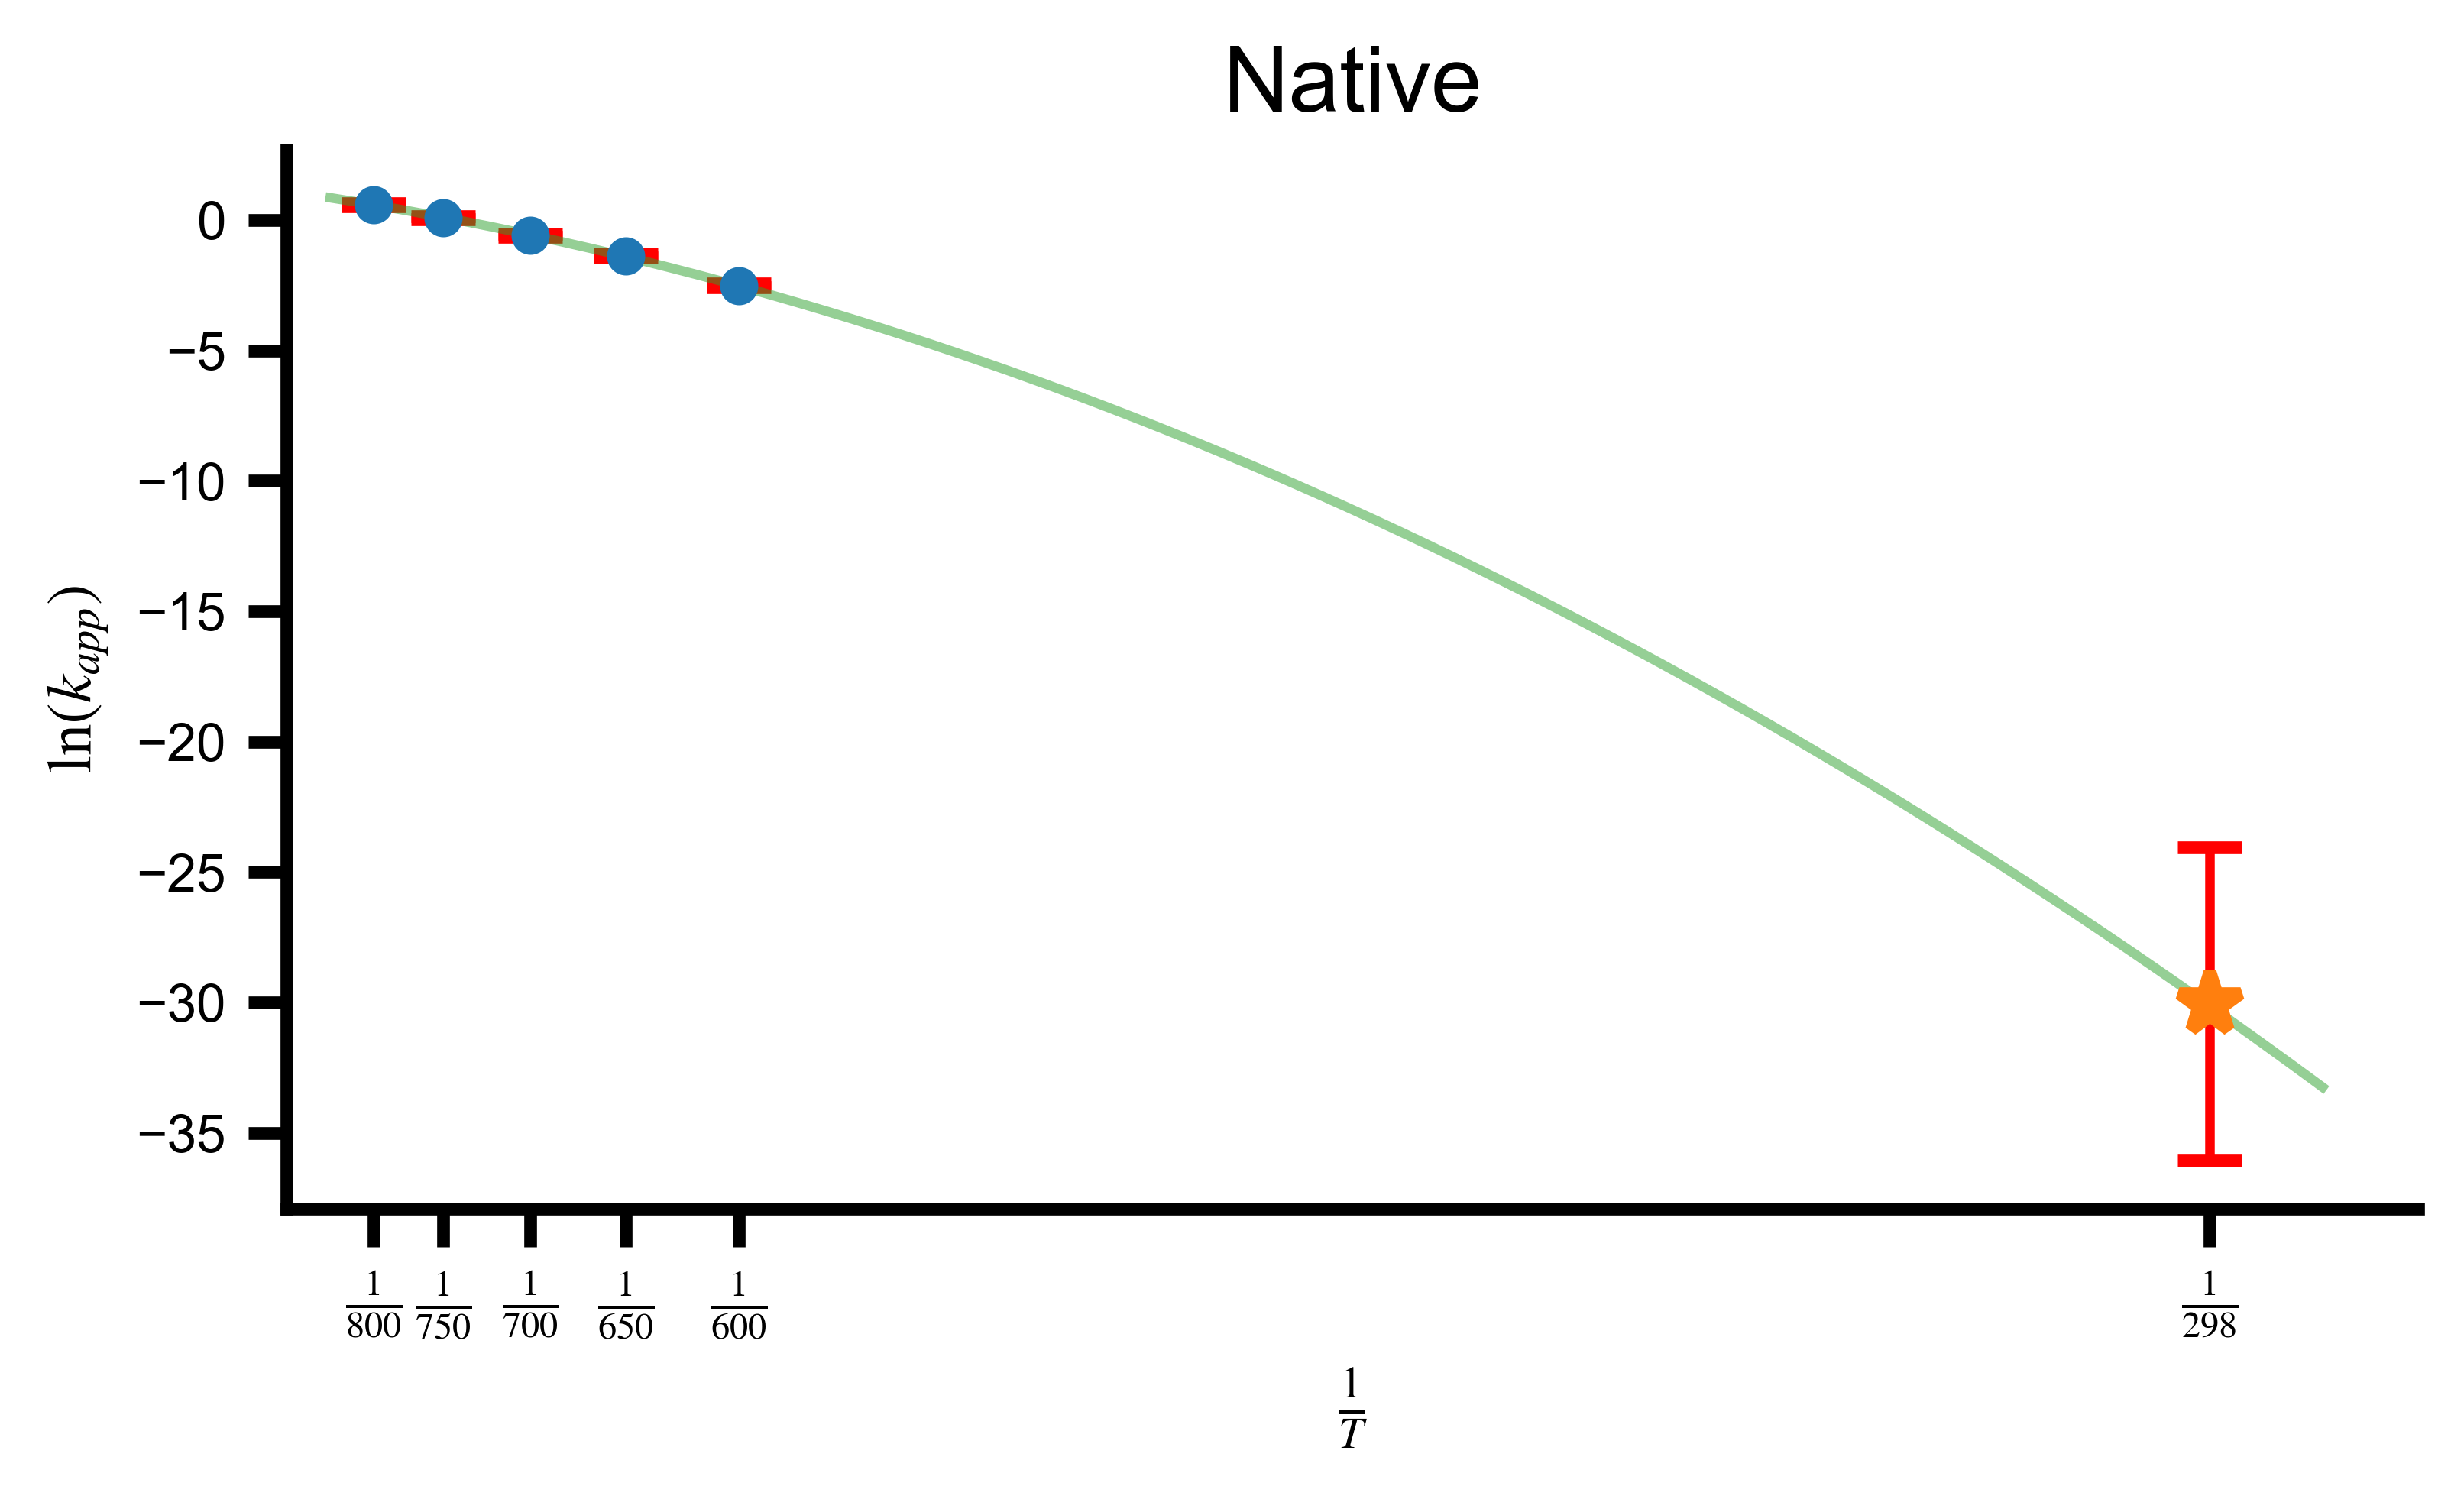

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt

# Define the data as a multiline string
data = """0.00125 0.592 0.533 0.653
0.00133 0.094 0.042 0.143
0.00143 -0.580 -0.639 -0.517
0.00154 -1.361 -1.427 -1.289
0.00167 -2.502 -2.583 -2.421
0.00336 -30.025 -36.060 -24.047"""

T_range=np.arange(0.0012, 0.0035, 0.00001)

# Parse the data
lines = data.split('\n')
x = []
mean = []
lower_bound = []
upper_bound = []

for line in lines:
    cols = line.split()
    x.append(float(cols[0]))
    mean.append(float(cols[1]))
    lower_bound.append(float(cols[2]))
    upper_bound.append(float(cols[3]))

x = np.array(x)
mean = np.array(mean)
lower_bound = np.array(lower_bound)
upper_bound = np.array(upper_bound)

# Calculate the error values
error_lower = mean - lower_bound
error_upper = upper_bound - mean
errors = [error_lower, error_upper]

x_labels = [r'$\frac{1}{800}$', r'$\frac{1}{750}$', r'$\frac{1}{700}$', r'$\frac{1}{650}$', r'$\frac{1}{600}$', r'$\frac{1}{298}$']

# Plot the data with error bars
plt.figure(figsize=(6, 3))

plt.errorbar(x[:-1], mean[:-1], yerr=[error_lower[:-1], error_upper[:-1]], fmt='o', ecolor='red', capsize=5, capthick=2, markeredgewidth=2)
# plot extrapolated point, T=298K
plt.errorbar(x[-1], mean[-1], yerr=[[error_lower[-1]], [error_upper[-1]]], fmt='*', ecolor='red', capsize=5, capthick=2, markeredgewidth=2, markersize=10)


plt.plot(T_range, quadratic_fun(T_range, *mean_res[3]), alpha=0.5)
plt.xlabel(r'$\frac{1}{T}$')
plt.ylabel(r'$\ln(k_{app})$')

# Set the x-ticks and x-tick labels
plt.xticks(ticks=x, labels=x_labels)
plt.xlim(0.00115, 0.0036)

plt.title('Native')
# plt.grid(True)
# plt.show()
plt.savefig('native.png', dpi=1000)

In [14]:
T_range=np.arange(0.0012, 0.0035, 0.00001)
fx_fit = quadratic_fun(T_range, *mean_res[3])

In [15]:
datafitting = np.array([T_range, fx_fit]).T
np.savetxt('function.dat', datafitting, delimiter='\t', fmt = '%10.5f')